In [29]:
import numpy as np
from numpy.linalg import inv,matrix_rank,det
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import load_breast_cancer

# Load the California housing dataset
data = load_breast_cancer(as_frame=True) # Load as a DataFrame

X = data.data
y = data.target

print(X.head())

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst radius  worst texture  worst perimeter  \
0           

### (i) ###

In [30]:
# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Print the shapes of the datasets
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (455, 30), (455,)
Validation set shape: (57, 30), (57,)
Test set shape: (57, 30), (57,)


### (ii) ###

In [31]:
# Feature Selection using training data
# Combine into a single DataFrame
df = X_train.copy()
df['target'] = y_train

# Compute correlation with the target
correlations = df.corr()['target'].drop('target')
print("Correlations with target:")
print(correlations.abs().sort_values(ascending=False))

# Filter features with |correlation| > 0.5
filtered_features = correlations[correlations.abs()>0.5].index.tolist()
print("\nFiltered features with absolute correction > 0.5:")
print(filtered_features)

# Drop features highly correlated with each other (|corr| > 0.9)
selected_features = []
cor_matrix = df[filtered_features].corr().abs()
for feature in filtered_features:
    # Check if it's highly correlated with any already selected feature
    if all(cor_matrix.loc[feature, selected] <= 0.9 for selected in selected_features):
        # all(iterable): returns True if all elements of an iterable are True.
        #                all([]) returns True by definition
        selected_features.append(feature)
print("Final Selected features:")
print(selected_features)

# Subset the DataFrame to only include the selected features.
df_train = X_train[selected_features]
df_val = X_val[selected_features]
df_test = X_test[selected_features]

# Print the shapes of the datasets
print(f"Training set shape after feature selection: {df_train.shape}, {y_train.shape}")
print(f"Validation set shape after feature selection: {df_val.shape}, {y_val.shape}")
print(f"Test set shape after feature selection: {df_test.shape}, {y_test.shape}")



Correlations with target:
worst concave points       0.788885
mean concave points        0.778115
worst perimeter            0.774998
worst radius               0.766527
mean perimeter             0.731859
worst area                 0.722875
mean radius                0.718073
mean area                  0.695171
mean concavity             0.683262
worst concavity            0.649952
mean compactness           0.590554
worst compactness          0.588884
radius error               0.540126
perimeter error            0.529211
area error                 0.517064
worst texture              0.467479
worst symmetry             0.440323
worst smoothness           0.430364
mean texture               0.416213
concave points error       0.380240
mean smoothness            0.375137
mean symmetry              0.348123
worst fractal dimension    0.312994
compactness error          0.254370
concavity error            0.216047
smoothness error           0.058123
fractal dimension error    0.041727
me

### (iii) ###

In [32]:
# check if X^T * X is invertible
def check_inverse_rank(matrix):
    rank = matrix_rank(matrix, tol=1e-12)
    print("matrix rank is : "+ str(rank))
    print("matrix size is : "+ str(matrix.shape))

    if matrix.shape[0] == matrix.shape[1]:
       if rank == matrix.shape[0]:
           print("matrix is invertible")
       else:
           print("matrix is not invertible")
    else:
       print("matrix is not square, hence not invertible")

    return (rank == matrix.shape[0]) and (matrix.shape[0] == matrix.shape[1])

def check_inverse_det(matrix, tol=1e-12):
    deter = det(matrix)
    print("determinant is : " + str(deter))
    if abs(deter) < tol:
        print("matrix is invertible")
    else:
        print("matrix is not invertible")

In [33]:
order = 1
threshold = 0.5
lamda = 0.00001

# Augment 1 to X
Poly = PolynomialFeatures(order)
X_train_poly = Poly.fit_transform(df_train)
X_val_poly = Poly.fit_transform(df_val)
X_test_poly = Poly.fit_transform(df_test)
    
# Fit a linear regression model
if check_inverse_rank(X_train_poly.T @ X_train_poly):
    print("Applying linear regression without regularization")
    w = inv(X_train_poly.T @ X_train_poly) @ X_train_poly.T @ y_train
else:
    print("Applying linear regression with regularization")
    w = inv(X_train_poly.T @ X_train_poly + lamda * np.eye(X_train_poly.shape[1])) @ X_train_poly.T @ y_train

print(f"w: {w}")

# Predict on the training, validation, and test sets
y_train_pred = ((X_train_poly @ w)>threshold).astype(int)
y_val_pred = ((X_val_poly @ w)>threshold).astype(int)
y_test_pred = ((X_test_poly @ w)>threshold).astype(int)
    
# Calculate and print the accuracy for training, validation sets and test sets
acc_train = accuracy_score(y_train, y_train_pred)
acc_val = accuracy_score(y_val, y_val_pred)
acc_test = accuracy_score(y_test, y_test_pred)
print(f"Training acc: {acc_train}, Validation acc: {acc_val}, Test acc: {acc_test}")
cm_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix for Test Set:")
print(cm_test)

matrix rank is : 8
matrix size is : (8, 8)
matrix is invertible
Applying linear regression without regularization
w: [ 1.59200106 -0.03236039  2.5190758  -0.26401624 -0.25492417 -0.69872181
  0.0374111  -4.16286245]
Training acc: 0.9340659340659341, Validation acc: 0.9122807017543859, Test acc: 0.9473684210526315
Confusion Matrix for Test Set:
[[14  2]
 [ 1 40]]


### (iv) ###

In [34]:
# Compute prediction, cost and gradient based on binary cross entropy
def logistic_cost_gradient(X, w, y, eps=1e-15):
    z = X @ w  # Linear combination
    
    pred_y = 1/(1+np.exp(-z))
    # Clip predictions to prevent log(0)
    pred_y = np.clip(pred_y, eps, 1 - eps)

    N = X.shape[0]  # Number of samples
    cost   = np.mean(- (y * np.log(pred_y) + (1 - y) * np.log(1 - pred_y)))
    gradient = ((pred_y-y) @ X)/ N  # Normalize by number of samples

    return pred_y, cost, gradient

In [35]:
# Perform binormial logistic regression
def binormial_logistic_regression(P, w, y, lr, num_iters):
    pred_y, cost, gradient = logistic_cost_gradient(P, w, y)
    print('Initial Cost =', cost)
    print('Initial w =', w)
    cost_vec = np.zeros(num_iters+1)
    cost_vec[0] = cost

    for i in range(1, num_iters + 1):
        w -= lr * gradient
        pred_y, cost, gradient = logistic_cost_gradient(P, w, y)
        cost_vec[i] = cost
        if i % 2000 == 0:
            print(f"Iteration {i}, Cost: {cost}")
    return w, cost_vec, pred_y      

In [36]:

lr_list = [0.1, 0.01, 0.001]
acc_train_list_Log = [] # store training accuracy for each learning rate
acc_val_list_Log = [] # store validation accuracy for each learning rate
num_iters = 20000
threshold = 0.5
order = 1 # linear features
cost_dict = {}  # a dictionary with key to be the learning rate, and value to be the cost.
max_val_acc = 0
best_lr = 0

# Create polynomial features X to P
Poly = PolynomialFeatures(order)
X_train_poly = Poly.fit_transform(df_train)
X_val_poly = Poly.fit_transform(df_val)
X_test_poly = Poly.fit_transform(df_test)

for lr in lr_list:
    # Initialize weights
    np.random.seed(42)  # set the seed for the random number generator for reproducibility
    w = np.random.randn(X_train_poly.shape[1])# 1D array of random values sampled from the standard normal distribution

    # Fit a logistic regression model
    print(f"Fitting logistic regression for learning rate {lr}...")
    w_opt, cost_vec, y_train_pred = binormial_logistic_regression(X_train_poly, w, y_train, lr, num_iters)
    print(f"w for learning rate {lr}: {w_opt}")

    # Compute training and validation accuracies.
    train_acc = accuracy_score(y_train, (y_train_pred > threshold).astype(int))
    y_val_pred,_,_ = logistic_cost_gradient(X_val_poly, w_opt, y_val)
    val_acc = accuracy_score(y_val, (y_val_pred > threshold).astype(int))
    print(f"Training accuracy for learning rate {lr}: {train_acc}")
    print(f"Validation accuracy for learning rate {lr}: {val_acc} \n")
    acc_val_list_Log.append(val_acc)
    acc_train_list_Log.append(train_acc)

    # store cost
    cost_dict[lr] = cost_vec

    # Check for best validation accuracy for hyperparameter selection
    if val_acc > max_val_acc:
        max_val_acc = val_acc
        best_lr = lr
        y_test_pred,_,_ = logistic_cost_gradient(X_test_poly, w_opt, y_test)
        test_acc = accuracy_score(y_test, (y_test_pred > threshold).astype(int))
        cm_test = confusion_matrix(y_test, (y_test_pred > threshold).astype(int))

print(f"Best learning rate: {best_lr}, Max validation accuracy: {max_val_acc}")
print(f"Test accuracy for the best model: {test_acc}")
print("Confusion Matrix for Test Set:")
print(cm_test)


Fitting logistic regression for learning rate 0.1...
Initial Cost = 0.8995876957253418
Initial w = [ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473]
Iteration 2000, Cost: 0.20594016284595282
Iteration 4000, Cost: 0.19494196005356174
Iteration 6000, Cost: 0.1889372393795804
Iteration 8000, Cost: 0.18513515981038245
Iteration 10000, Cost: 0.18249773297433164
Iteration 12000, Cost: 0.1805452399001726
Iteration 14000, Cost: 0.17902571333633896
Iteration 16000, Cost: 0.17779486255065383
Iteration 18000, Cost: 0.17676463650233226
Iteration 20000, Cost: 0.17587859184473675
w for learning rate 0.1: [15.54668046 -0.72585932  0.60544684 -0.29441768 -4.61324281 -4.62896759
 -4.26056365 -4.15651439]
Training accuracy for learning rate 0.1: 0.9186813186813186
Validation accuracy for learning rate 0.1: 0.9298245614035088 

Fitting logistic regression for learning rate 0.01...
Initial Cost = 0.8995876957253418
Initial w = [ 0.49671415 -0.1382643   0.64

Training acc:  [0.9186813186813186, 0.9142857142857143, 0.8307692307692308]
Validation acc:  [0.9298245614035088, 0.9122807017543859, 0.7894736842105263]


Text(0.5, 1.0, 'Binomial Logistic Regression')

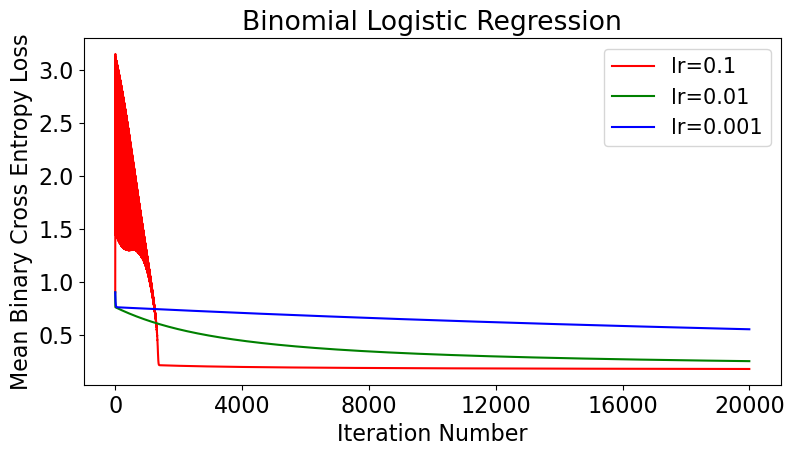

In [37]:
print('Training acc: ', str(acc_train_list_Log))
print('Validation acc: ', str(acc_val_list_Log))
# Plot cost values over iterations for each learning rate
plt.figure(0, figsize=[9,4.5])
plt.rcParams.update({'font.size': 16})
colors = ['r', 'g', 'b']

for i, (lr, cost_vec) in enumerate(cost_dict.items()): #.items(): iterable of key-value pairs
                                                       # enumerate(): Adds an index to each element of an iterable
    plt.plot(np.arange(0, num_iters+1, 1), cost_vec, color=colors[i], label=f'lr={lr}')
             # np.arange(start, stop, step)
plt.legend(loc='upper right', fontsize=15)
plt.xlabel('Iteration Number')
plt.ylabel('Mean Binary Cross Entropy Loss')
plt.xticks(np.arange(0, num_iters+1, 4000))
plt.title('Binomial Logistic Regression')

# Using sklearn's Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(df_train, y_train)
print("model coefficients:", model.coef_)
print("model intercept:", model.intercept_)
y_pred_train = model.predict(df_train)
train_acc = accuracy_score(y_train, y_pred_train)
y_pred_val = model.predict(df_val)
val_acc = accuracy_score(y_val, y_pred_val)
y_pred_test = model.predict(df_test)
test_acc = accuracy_score(y_test, y_pred_test)
print(f"Training accuracy using sklearn: {train_acc}")
print(f"Validation accuracy using sklearn: {val_acc}")
print(f"Test accuracy using sklearn: {test_acc}")

model coefficients: [[-0.78750839 -0.51577771 -0.8525225  -2.03692769 -2.57481351 -3.14838334
  -1.37161964]]
model intercept: [14.42205574]
Training accuracy using sklearn: 0.9010989010989011
Validation accuracy using sklearn: 0.9298245614035088
Test accuracy using sklearn: 1.0
